In [1]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
import os

# Beer Advocate Analysis

In [2]:
ba_reviews = pd.read_parquet('../generated/new_ba_reviews.parquet')

In [4]:
#sélectionner que les experts
experts = pd.read_csv('../data/exp_user.csv')
experts.head()

,user_id,platform,total_reviews,usage_duration,style_diversity,mean_time_spacing,std_time_spacing
0,nmann08.184925,BeerAdvocate,465,3493.0,81,2.961207,17.926253
1,stjamesgate.163714,BeerAdvocate,2504,3584.0,93,1.273672,4.020508
2,mdagnew.19527,BeerAdvocate,1143,4457.0,87,3.503503,7.180989
3,cypressbob.3708,BeerAdvocate,604,5002.0,81,4.262023,20.940931
4,agentmunky.409755,BeerAdvocate,1990,2771.0,94,1.348919,2.711835


In [5]:
import pandas as pd
print(len(ba_reviews))
experts_ba = experts[experts['platform'] == 'BeerAdvocate']
print(len(experts_ba))
# Step 2: Get the unique user_ids from the filtered second dataset
valid_user_ids = experts_ba['user_id'].unique()
print(len(valid_user_ids))
# Step 3: Filter the first dataset
ba_reviews_exp = ba_reviews[ba_reviews['user_id'].isin(valid_user_ids)]
print(len(ba_reviews_exp))


2589584
4055
4055
1989304


## Language detection

In [8]:
import time
import os
from langdetect import detect

# Ensure the output directory exists
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

chunk_size = 10000  # Process 100,000 rows at a time
chunks = [ba_reviews_exp.iloc[i:i + chunk_size] for i in range(0, len(ba_reviews_exp), chunk_size)]

for i, chunk in enumerate(chunks):
    start_time = time.time()  # Start the timer
    
    # Apply language detection
    chunk["language"] = chunk["text"].apply(detect_language)
    
    # Save the chunk to a CSV file
    output_path = f'{output_dir}/ba_reviews_language_chunk_{i}.csv'
    chunk.to_csv(output_path, index=False)
    
    # Calculate and log the time taken
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Chunk {i} completed. Time taken: {elapsed_time:.2f} seconds. Saved to: {output_path}")

Chunk 0 completed. Time taken: 38.32 seconds. Saved to: ./output/ba_reviews_language_chunk_0.csv
Chunk 1 completed. Time taken: 41.63 seconds. Saved to: ./output/ba_reviews_language_chunk_1.csv
Chunk 2 completed. Time taken: 45.24 seconds. Saved to: ./output/ba_reviews_language_chunk_2.csv
Chunk 3 completed. Time taken: 43.68 seconds. Saved to: ./output/ba_reviews_language_chunk_3.csv
Chunk 4 completed. Time taken: 50.45 seconds. Saved to: ./output/ba_reviews_language_chunk_4.csv
Chunk 5 completed. Time taken: 63.41 seconds. Saved to: ./output/ba_reviews_language_chunk_5.csv
Chunk 6 completed. Time taken: 54.38 seconds. Saved to: ./output/ba_reviews_language_chunk_6.csv
Chunk 7 completed. Time taken: 45.62 seconds. Saved to: ./output/ba_reviews_language_chunk_7.csv
Chunk 8 completed. Time taken: 40.44 seconds. Saved to: ./output/ba_reviews_language_chunk_8.csv
Chunk 9 completed. Time taken: 47.63 seconds. Saved to: ./output/ba_reviews_language_chunk_9.csv
Chunk 10 completed. Time taken

   language    count  percentage
0        en  1988976       99.98
1        fr      290        0.01
2        es       11        0.00
3        nl        5        0.00
4        de        4        0.00
5        af        4        0.00
6        no        4        0.00
7        ca        2        0.00
8        it        2        0.00
9        et        2        0.00
10       da        1        0.00
11       pl        1        0.00
12       sv        1        0.00
13       id        1        0.00


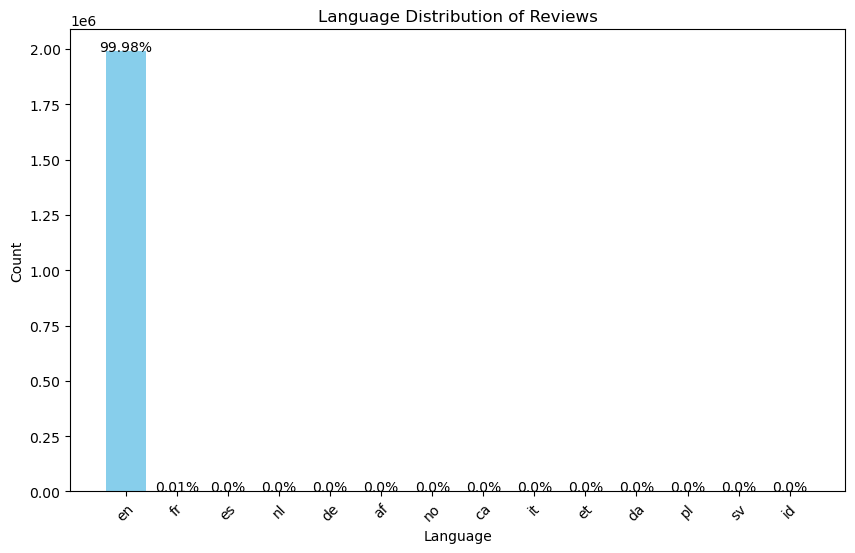

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Directory where chunks are saved
output_dir = './output'

# Step 1: Combine all chunks into one DataFrame
chunk_files = [f for f in os.listdir(output_dir) if f.startswith("ba_reviews_language_chunk_")]
combined_df = pd.concat([pd.read_csv(os.path.join(output_dir, file)) for file in chunk_files])

# Step 2: Perform language distribution analysis
language_distribution = combined_df["language"].value_counts()
language_distribution_df = language_distribution.reset_index()
language_distribution_df.columns = ["language", "count"]

# Calculate percentages
total_reviews = language_distribution_df["count"].sum()
language_distribution_df["percentage"] = (language_distribution_df["count"] / total_reviews * 100).round(2)

print(language_distribution_df)

# Step 3: Plot the language distribution
plt.figure(figsize=(10, 6))
plt.bar(language_distribution_df["language"], language_distribution_df["count"], color="skyblue")
plt.title("Language Distribution of Reviews")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add percentages as text above the bars
for i, (count, percentage) in enumerate(zip(language_distribution_df["count"], language_distribution_df["percentage"])):
    plt.text(i, count + 1, f"{percentage}%", ha="center")

plt.show()


Comme 99.98% des reviews des experts sont en anglais, on peut se concentrer d'analyser les sentiments de cuex-ci.

In [18]:
english_reviews = df_subset[df_subset["language"] == "en"]

english_reviews = english_reviews.reset_index(drop=True)

## Sentimental analysis

In [10]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zoemonnard/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
import time
import os
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Directory where chunks are saved
input_dir = './output'
output_dir = './output_with_sentiment'
os.makedirs(output_dir, exist_ok=True)

# Function to analyze sentiment and classify it directly
def analyze_and_classify_sentiment(text):
    scores = analyzer.polarity_scores(text)  # Get sentiment scores
    compound_score = scores['compound']
    if compound_score >= 0.05:
        sentiment_label = "positive"
    elif compound_score <= -0.05:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"
    return scores, sentiment_label

# Get all chunk files
chunk_files = [f for f in os.listdir(input_dir) if f.startswith("ba_reviews_language_chunk_")]

for i, chunk_file in enumerate(chunk_files):
    start_time = time.time()  # Start timer

    # Load the chunk
    chunk_path = os.path.join(input_dir, chunk_file)
    chunk = pd.read_csv(chunk_path)

    # Filter only English reviews
    english_reviews = chunk[chunk["language"] == "en"]

    # Analyze sentiment and classify it directly
    sentiment_results = english_reviews["text"].apply(analyze_and_classify_sentiment)
    english_reviews["sentiment_scores"] = sentiment_results.apply(lambda x: x[0])  # Add full sentiment scores
    english_reviews["sentiment_label"] = sentiment_results.apply(lambda x: x[1])   # Add sentiment label

    # Save the processed chunk with sentiment analysis
    output_path = os.path.join(output_dir, f"sentiment_{chunk_file}")
    english_reviews.to_csv(output_path, index=False)

    # Log time taken
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Chunk {i} completed. Time taken: {elapsed_time:.2f} seconds. Saved to: {output_path}")

Chunk 0 completed. Time taken: 11.52 seconds. Saved to: ./output_with_sentiment/sentiment_ba_reviews_language_chunk_138.csv
Chunk 1 completed. Time taken: 11.06 seconds. Saved to: ./output_with_sentiment/sentiment_ba_reviews_language_chunk_110.csv
Chunk 2 completed. Time taken: 11.24 seconds. Saved to: ./output_with_sentiment/sentiment_ba_reviews_language_chunk_98.csv
Chunk 3 completed. Time taken: 12.99 seconds. Saved to: ./output_with_sentiment/sentiment_ba_reviews_language_chunk_104.csv
Chunk 4 completed. Time taken: 13.78 seconds. Saved to: ./output_with_sentiment/sentiment_ba_reviews_language_chunk_73.csv
Chunk 5 completed. Time taken: 14.84 seconds. Saved to: ./output_with_sentiment/sentiment_ba_reviews_language_chunk_67.csv
Chunk 6 completed. Time taken: 16.78 seconds. Saved to: ./output_with_sentiment/sentiment_ba_reviews_language_chunk_66.csv
Chunk 7 completed. Time taken: 12.09 seconds. Saved to: ./output_with_sentiment/sentiment_ba_reviews_language_chunk_72.csv
Chunk 8 compl

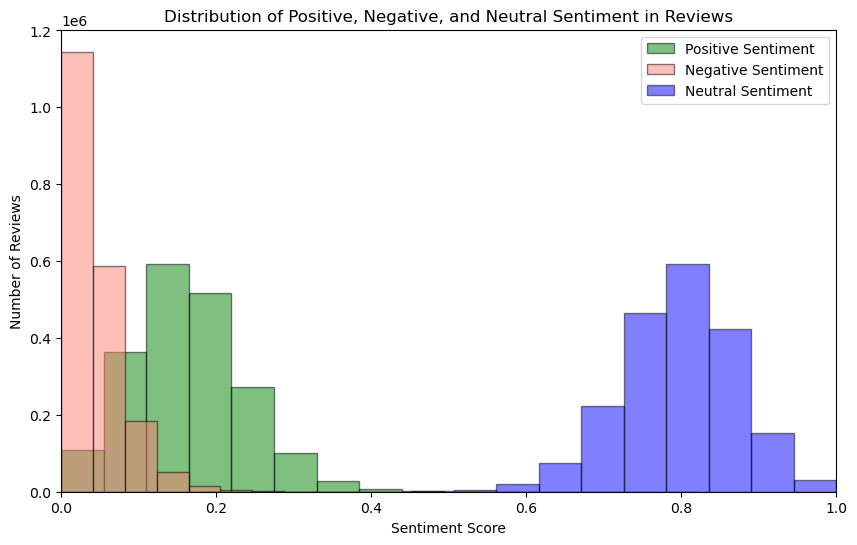

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt

output_dir = './output_with_sentiment'

# Step 1: Combine all chunks into one DataFrame
chunk_files = [f for f in os.listdir(output_dir) if f.startswith("sentiment_")]
combined_df = pd.concat([pd.read_csv(os.path.join(output_dir, file)) for file in chunk_files])

combined_df["positive_sentiment"] = combined_df["sentiment_scores"].apply(eval).apply(lambda x: x['pos'])
combined_df["negative_sentiment"] = combined_df["sentiment_scores"].apply(eval).apply(lambda x: x['neg'])
combined_df["neutral_sentiment"] = combined_df["sentiment_scores"].apply(eval).apply(lambda x: x['neu'])

# Step 3: Plot the histograms on the same graph
plt.figure(figsize=(10, 6))
plt.hist(
    combined_df["positive_sentiment"], bins=15, alpha=0.5, edgecolor='black', label="Positive Sentiment", color='green'
)
plt.hist(
    combined_df["negative_sentiment"], bins=15, alpha=0.5, edgecolor='black', label="Negative Sentiment", color='salmon'
)
plt.hist(
    combined_df["neutral_sentiment"], bins=15, alpha=0.5, edgecolor='black', label="Neutral Sentiment", color='blue'
)
plt.xlim([0, 1])
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Positive, Negative, and Neutral Sentiment in Reviews")
plt.legend()
plt.show()

Negative Sentiment:
There is a significant concentration of reviews with a negative sentiment score close to 0.0.The number of reviews with higher negative sentiment scores (closer to 1.0) drops sharply, indicating that most reviews have low negativity.

Positive Sentiment:
Positive sentiment scores are more evenly distributed compared to negative scores. A notable portion of reviews has a positive sentiment score between 0.1 and 0.3, showing a slightly positive tone in many reviews.

There is a strong concentration of neutral reviews, peaking near 0.8, showing that a large portion of reviews may lack a strong positive or negative emotional tone.

Most reviews have low negative sentiment scores, which implies that reviewers tend to avoid expressing strong negativity.There is a stronger emphasis on mildly positive sentiment, as seen in the distribution of green bars peaking around 0.2. A significant number of reviews are classified as neutral (score > 0.5), highlighting that a lot of feedback might be descriptive or lacking emotional extremes.

Engagement Style:
The higher proportion of low negative scores could suggest that the community or platform encourages positive or neutral feedback rather than overly critical reviews. The review community might prefer providing constructive or balanced feedback rather than overtly critical or overwhelmingly positive reviews.
Neutral sentiment dominance could indicate that users focus on facts or descriptions rather than expressing strong opinions.

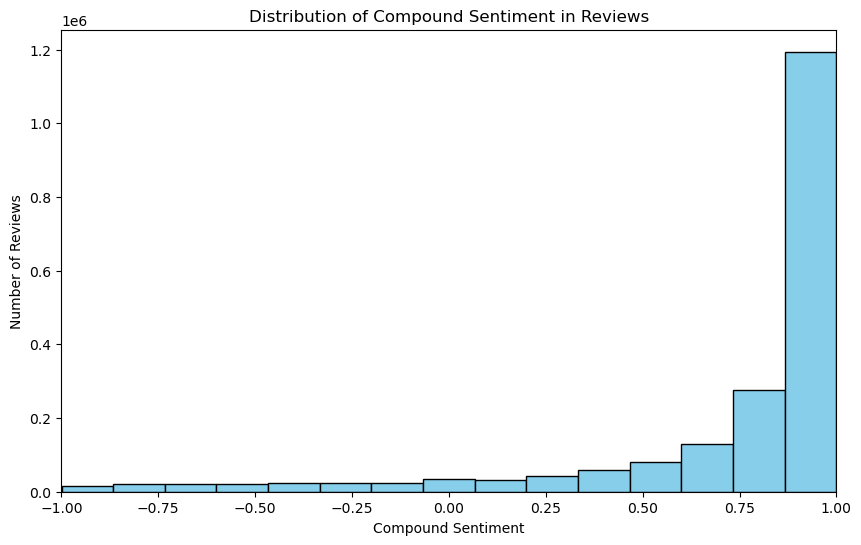

In [24]:
combined_df["compound_sentiment"] = combined_df["sentiment_scores"].apply(eval).apply(lambda x: x['compound'])

# Step 3: Plot the histogram of compound sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(combined_df["compound_sentiment"], bins=15, edgecolor='black', color='skyblue')
plt.xlim([-1, 1])  # Compound scores range from -1 to 1
plt.xlabel("Compound Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Compound Sentiment in Reviews")
plt.show()


While pos, neu, and neg provide granular scores for each sentiment type, the compound score gives an overall measure of sentiment in a single value. It's particularly useful for quick sentiment classification.

Peak at 1.0 (Strong Positive Sentiment):
There is a significant spike in the number of reviews with a compound sentiment score of 1.0. This indicates that a large number of reviews express strong positivity.
Low Frequency for Negative Scores (-1.0 to 0):
The number of reviews with negative scores is minimal, suggesting that strongly negative feedback is rare in this dataset.
Gradual Increase in Positive Scores (0 to 1.0):
Reviews with positive sentiment scores increase steadily as the compound score approaches 1.0.

                   count  percentage
sentiment_label                     
positive         1815647       91.29
negative          146685        7.37
neutral            26644        1.34


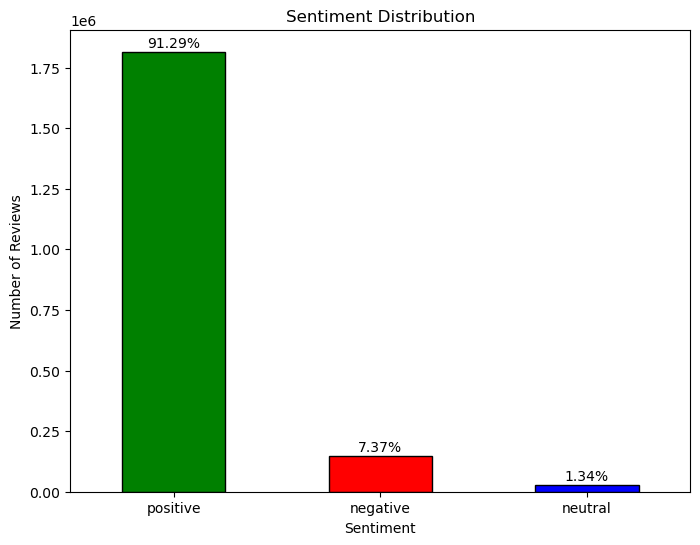

In [25]:
sentiment_counts = combined_df["sentiment_label"].value_counts()
total_reviews = sentiment_counts.sum()
sentiment_percentages = (sentiment_counts / total_reviews * 100).round(2)

# Step 3: Create a DataFrame for sentiment analysis
sentiment_analysis = pd.DataFrame({
    "count": sentiment_counts,
    "percentage": sentiment_percentages
})

print(sentiment_analysis)

# Step 4: Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind="bar", color=["green", "red", "blue"], edgecolor="black")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)

# Add percentages on top of the bars
for index, value in enumerate(sentiment_counts):
    percentage = sentiment_percentages.iloc[index]
    plt.text(index, value + total_reviews * 0.01, f"{percentage}%", ha="center", fontsize=10)

plt.show()

Positive Sentiment (91.29%):
The vast majority of reviews (over 91%) are classified as positive. This suggests that most users are expressing favorable opinions or experiences in their reviews.
This high proportion could reflect the general satisfaction of reviewers with the beers or the tendency of users to write positive feedback rather than critical or neutral comments.
Negative Sentiment (7.37%):
A smaller proportion of reviews are negative. This indicates that while some criticism exists, it is much less common compared to positive feedback.
It may suggest a culture of leniency among reviewers, or it could be that beers receiving negative reviews are exceptions rather than the norm.
Neutral Sentiment (1.34%):
Neutral reviews make up the smallest portion of the dataset. This indicates that users typically lean toward expressing either positive or negative sentiments rather than remaining neutral.
Neutral reviews might correspond to descriptive or fact-based feedback without strong emotional tones.

Why in neu high in sentiment_scores but we have low neutral reviews ??

The neu value in the sentiment_scores indicates the proportion of the text that is considered neutral by the sentiment analyzer. A high neu score does not necessarily mean the review is entirely neutral in tone. It simply suggests that the text contains a significant amount of neutral content (e.g., factual descriptions or non-emotional language).
How Compound Scores Determine Sentiment Labels :
The sentiment label (positive, negative, neutral) is determined based on the compound score:
Compound score ≥ 0.05 → Positive
Compound score ≤ -0.05 → Negative
-0.05 < Compound score < 0.05 → Neutral
Even if a review has a high neu score, it might still have a sufficiently high compound score to be labeled as positive or negative.

High neu Scores in Positive or Negative Reviews:
Many reviews may have a mix of neutral and emotional language.
A review like "The beer has a smooth texture and a pleasant taste" might have a high neu score for its descriptive language but still register a high compound score because of positive words like "smooth" and "pleasant." Similarly, "The beer lacks flavor and is quite bland" may also have a high neu score for its descriptive content but a low compound score due to negative words like "lacks" and "bland."

Why neutral Sentiment Labels Are Low:
The compound score threshold for a "neutral" label (-0.05 < compound < 0.05) is narrow, so most reviews with high neu scores still fall into the positive or negative categories based on small emotional signals.

What High neu Coefficients Tell Us:
Many reviews may be fact-heavy or descriptive but still contain enough emotional cues to lean positive or negative in their compound score.This could suggest that reviewers tend to describe beers objectively (e.g., texture, aroma, flavor) while subtly expressing a sentiment. -> see later in language analysis
Avoid overtly emotional language, resulting in high neu values even in strongly positive or negative reviews.

# Rate beer analysis

In [3]:
rb_reviews = pd.read_parquet('../generated/new_rb_reviews.parquet')

In [7]:
#sélectionner que les experts
experts = pd.read_csv('../data/exp_user.csv')
experts.head()

,user_id,platform,total_reviews,usage_duration,style_diversity,mean_time_spacing,std_time_spacing
0,nmann08.184925,BeerAdvocate,465,3493.0,81,2.961207,17.926253
1,stjamesgate.163714,BeerAdvocate,2504,3584.0,93,1.273672,4.020508
2,mdagnew.19527,BeerAdvocate,1143,4457.0,87,3.503503,7.180989
3,cypressbob.3708,BeerAdvocate,604,5002.0,81,4.262023,20.940931
4,agentmunky.409755,BeerAdvocate,1990,2771.0,94,1.348919,2.711835


In [8]:
print(len(rb_reviews))
experts_rb = experts[experts['platform'] == 'RateBeer']
print(len(experts_rb))
# Step 2: Get the unique user_ids from the filtered second dataset
valid_user_ids2 = experts_rb['user_id'].unique()
print(len(valid_user_ids2))
# Step 3: Filter the first dataset
rb_reviews_exp = rb_reviews[rb_reviews['user_id'].isin(valid_user_ids2)]
print(len(rb_reviews_exp))

7121626
5367
5367
6511772


In [ ]:
#A supprimer
import pandas as pd

user_review_counts = rb_reviews_exp.groupby('user_id').size().reset_index(name='review_count')

# Step 2: Sort users by review_count in descending order
user_review_counts = user_review_counts.sort_values(by='review_count', ascending=False)

# Step 3: Calculate the threshold for the top 5% of users
top_5_percent_threshold = int(len(user_review_counts) * 0.0003)

# Step 4: Select the top 5% of user_ids
top_5_percent_users = user_review_counts.head(top_5_percent_threshold)

# Extract the user_ids of the top 5% users
top_user_ids = top_5_percent_users['user_id']

# Step 5: Filter the original dataset to include only reviews from these top users
rb_reviews_filt = rb_reviews_exp[rb_reviews_exp['user_id'].isin(top_user_ids)]
print(len(rb_reviews_filt))
# Save or display the filtered dataset
# filtered_dataset.to_csv('filtered_dataset.csv', index=False)

## Laguage detection

In [ ]:
# A run
# Ensure the output directory exists for RateBeer dataset
from langdetect import detect
output_dir = './output_rb_reviews'
os.makedirs(output_dir, exist_ok=True)

def detect_language(text):
    try:
        return detect(text)
    except Exception as e:
        return "unknown"  # Handle detection failures gracefully

chunk_size = 10000  # Process 10,000 rows at a time
chunks = [rb_reviews_exp.iloc[i:i + chunk_size] for i in range(0, len(rb_reviews_exp), chunk_size)]

for i, chunk in enumerate(chunks):
    start_time = time.time()  # Start the timer
    
    # Apply language detection
    chunk["language"] = chunk["text"].apply(detect_language)
    
    # Save the chunk to a CSV file
    output_path = f'{output_dir}/rb_reviews_language_chunk_{i}.csv'
    chunk.to_csv(output_path, index=False)
    
    # Calculate and log the time taken
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Chunk {i} completed. Time taken: {elapsed_time:.2f} seconds. Saved to: {output_path}")

Chunk 0 completed. Time taken: 47.94 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_0.csv
Chunk 1 completed. Time taken: 46.72 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_1.csv
Chunk 2 completed. Time taken: 41.89 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_2.csv
Chunk 3 completed. Time taken: 32.59 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_3.csv
Chunk 4 completed. Time taken: 41.80 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_4.csv
Chunk 5 completed. Time taken: 40.65 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_5.csv
Chunk 6 completed. Time taken: 35.51 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_6.csv
Chunk 7 completed. Time taken: 38.00 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_7.csv
Chunk 8 completed. Time taken: 52.64 seconds. Saved to: ./output_rb_reviews/rb_reviews_language_chunk_8.csv
Chunk 9 completed. Time take

In [ ]:
#A supprimer
import time
import os

# Ensure the output directory exists
output_dir = './outputrb'
os.makedirs(output_dir, exist_ok=True)

# Limit to the first 1 million rows
subset_reviews = rb_reviews_exp.iloc[:1000000]

# Define chunk size
chunk_size = 10000  # Process 10,000 rows at a time

# Split the subset into chunks
chunks = [subset_reviews.iloc[i:i + chunk_size] for i in range(0, len(subset_reviews), chunk_size)]

# Process each chunk
for i, chunk in enumerate(chunks):
    start_time = time.time()  # Start the timer
    
    # Apply language detection
    chunk["language"] = chunk["text"].apply(detect_language)
    
    # Save the chunk to a CSV file
    output_path = f'{output_dir}/rb_reviews_language_chunk_{i}.csv'
    chunk.to_csv(output_path, index=False)
    
    # Calculate and log the time taken
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Chunk {i} completed. Time taken: {elapsed_time:.2f} seconds. Saved to: {output_path}")


In [ ]:
#A supprimer
import pandas as pd
import matplotlib.pyplot as plt
import os

# Directory where chunks are saved
output_dir = './outputrb'

# Step 1: Combine all chunks into one DataFrame
chunk_files = [f for f in os.listdir(output_dir) if f.startswith("rb_reviews_language_chunk_")]
combined_df = pd.concat([pd.read_csv(os.path.join(output_dir, file)) for file in chunk_files])

# Step 2: Perform language distribution analysis
language_distribution = combined_df["language"].value_counts()
language_distribution_df = language_distribution.reset_index()
language_distribution_df.columns = ["language", "count"]

# Calculate percentages
total_reviews = language_distribution_df["count"].sum()
language_distribution_df["percentage"] = (language_distribution_df["count"] / total_reviews * 100).round(2)

print(language_distribution_df)

# Step 3: Plot the language distribution
plt.figure(figsize=(10, 6))
plt.bar(language_distribution_df["language"], language_distribution_df["count"], color="skyblue")
plt.title("Language Distribution of Reviews")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add percentages as text above the bars
for i, (count, percentage) in enumerate(zip(language_distribution_df["count"], language_distribution_df["percentage"])):
    plt.text(i, count + 1, f"{percentage}%", ha="center")

plt.show()

# A run
import pandas as pd
import matplotlib.pyplot as plt
import os

# Directory where RateBeer chunks are saved
output_dir = './output_rb_reviews'

# Step 1: Combine all RateBeer chunks into one DataFrame
chunk_files = [f for f in os.listdir(output_dir) if f.startswith("rb_reviews_language_chunk_")]
combined_df = pd.concat([pd.read_csv(os.path.join(output_dir, file)) for file in chunk_files])

# Step 2: Perform language distribution analysis
language_distribution = combined_df["language"].value_counts()
language_distribution_df = language_distribution.reset_index()
language_distribution_df.columns = ["language", "count"]

# Calculate percentages
total_reviews = language_distribution_df["count"].sum()
language_distribution_df["percentage"] = (language_distribution_df["count"] / total_reviews * 100).round(2)

print(language_distribution_df)

# Step 3: Plot the language distribution
plt.figure(figsize=(10, 6))
plt.bar(language_distribution_df["language"], language_distribution_df["count"], color="skyblue")
plt.title("Language Distribution of Reviews (RateBeer)")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add percentages as text above the bars
for i, (count, percentage) in enumerate(zip(language_distribution_df["count"], language_distribution_df["percentage"])):
    plt.text(i, count + 1, f"{percentage}%", ha="center")

plt.show()


## Sentimental Analysis

In [ ]:
import nltk
nltk.download('vader_lexicon')

In [36]:
# A run
from nltk.sentiment import SentimentIntensityAnalyzer
import time
import os
import pandas as pd

# Initialize SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Directories for input and output
input_dir = './output_rb_reviews'
output_dir = './output_rb_with_sentiment'
os.makedirs(output_dir, exist_ok=True)

# Function to analyze sentiment and classify it directly
def analyze_and_classify_sentiment(text):
    scores = analyzer.polarity_scores(text)  # Get sentiment scores
    compound_score = scores['compound']
    if compound_score >= 0.05:
        sentiment_label = "positive"
    elif compound_score <= -0.05:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"
    return scores, sentiment_label

# Get all chunk files
chunk_files = [f for f in os.listdir(input_dir) if f.startswith("rb_reviews_language_chunk_")]

for i, chunk_file in enumerate(chunk_files):
    start_time = time.time()  # Start timer

    # Load the chunk
    chunk_path = os.path.join(input_dir, chunk_file)
    chunk = pd.read_csv(chunk_path)

    # Filter only English reviews
    english_reviews = chunk[chunk["language"] == "en"]

    # Analyze sentiment and classify it directly
    sentiment_results = english_reviews["text"].apply(analyze_and_classify_sentiment)
    english_reviews["sentiment_scores"] = sentiment_results.apply(lambda x: x[0])  # Add full sentiment scores
    english_reviews["sentiment_label"] = sentiment_results.apply(lambda x: x[1])   # Add sentiment label

    # Save the processed chunk with sentiment analysis
    output_path = os.path.join(output_dir, f"sentiment_{chunk_file}")
    english_reviews.to_csv(output_path, index=False)

    # Log time taken
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Chunk {i} completed. Time taken: {elapsed_time:.2f} seconds. Saved to: {output_path}")

,text,sentiment_scores,sentiment
21,Bottle. [ As my country rating # 134 on ratebe...,"{'neg': 0.0, 'neu': 0.854, 'pos': 0.146, 'comp...",0.8555
80,Bottle 750ml. corked. [ As Boundary / Neill & ...,"{'neg': 0.019, 'neu': 0.821, 'pos': 0.16, 'com...",0.8885
166,Bottle 330ml. @ [ The Stat Improver Tasting ] ...,"{'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'comp...",0.9201
190,Bottle 330ml. @ [ The Stat Improver Tasting ] ...,"{'neg': 0.0, 'neu': 0.858, 'pos': 0.142, 'comp...",0.8834
452,Bottle 750ml. @ The Danish (Ulfborg) Ratebeer ...,"{'neg': 0.0, 'neu': 0.832, 'pos': 0.168, 'comp...",0.9169
516,Bottle 500ml. [ As McGraths Irish Blonde #5 ]....,"{'neg': 0.03, 'neu': 0.845, 'pos': 0.125, 'com...",0.7430
549,Bottle 500ml. [ As Clanconnel #2 McGrathâs I...,"{'neg': 0.036, 'neu': 0.895, 'pos': 0.069, 'co...",0.3612
595,Bottle 500ml. [ As Clanconnel #3 McGrathâs I...,"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",0.8779
657,Bottle 500ml.Clear medium to dark red amber co...,"{'neg': 0.049, 'neu': 0.849, 'pos': 0.102, 'co...",0.4767
737,"Cask (handpump) @ GBBF 2011, Great British Bee...","{'neg': 0.035, 'neu': 0.834, 'pos': 0.13, 'com...",0.8176


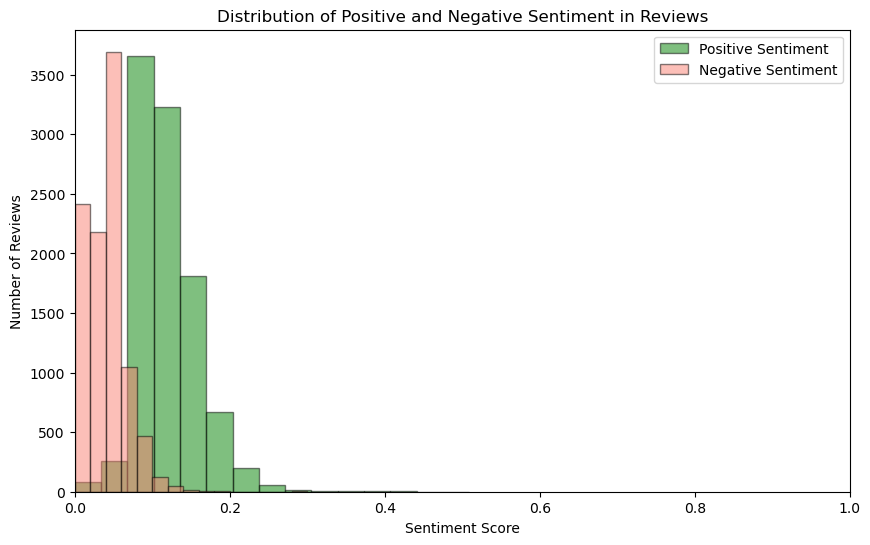

In [40]:
#A run
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory where RateBeer chunks with sentiment analysis are saved
input_dir = './output_rb_with_sentiment'

# Step 1: Combine all chunks into one DataFrame
chunk_files = [f for f in os.listdir(input_dir) if f.startswith("sentiment_rb_reviews_language_chunk_")]
combined_df = pd.concat([pd.read_csv(os.path.join(input_dir, file)) for file in chunk_files])

# Step 2: Extract positive, negative, and neutral sentiment scores
combined_df["positive_sentiment"] = combined_df["sentiment_scores"].apply(eval).apply(lambda x: x['pos'])
combined_df["negative_sentiment"] = combined_df["sentiment_scores"].apply(eval).apply(lambda x: x['neg'])
combined_df["neutral_sentiment"] = combined_df["sentiment_scores"].apply(eval).apply(lambda x: x['neu'])

# Step 3: Plot the histograms on the same graph
plt.figure(figsize=(10, 6))
plt.hist(
    combined_df["positive_sentiment"], bins=15, alpha=0.5, edgecolor='black', label="Positive Sentiment", color='green'
)
plt.hist(
    combined_df["negative_sentiment"], bins=15, alpha=0.5, edgecolor='black', label="Negative Sentiment", color='salmon'
)
plt.hist(
    combined_df["neutral_sentiment"], bins=15, alpha=0.5, edgecolor='black', label="Neutral Sentiment", color='blue'
)
plt.xlim([0, 1])
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Positive, Negative, and Neutral Sentiment in RateBeer Reviews")
plt.legend()
plt.show()


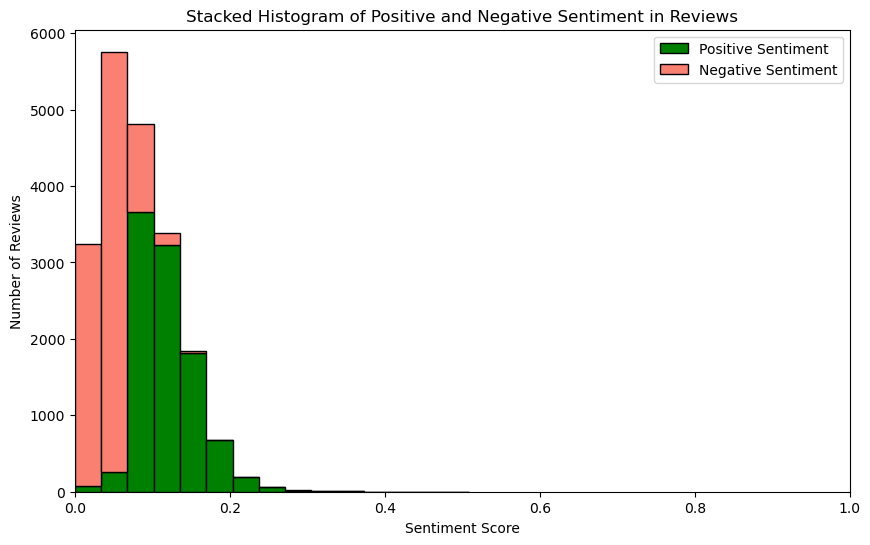

In [44]:
#A run
combined_df["compound_sentiment"] = combined_df["sentiment_scores"].apply(eval).apply(lambda x: x['compound'])

# Step 3: Plot the histogram of compound sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(combined_df["compound_sentiment"], bins=15, edgecolor='black', color='skyblue')
plt.xlim([-1, 1])  # Compound scores range from -1 to 1
plt.xlabel("Compound Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Compound Sentiment in Reviews")
plt.show()


                 count  percentage
sentiment_label                   
positive         42192       97.55
negative           816        1.89
neutral            243        0.56


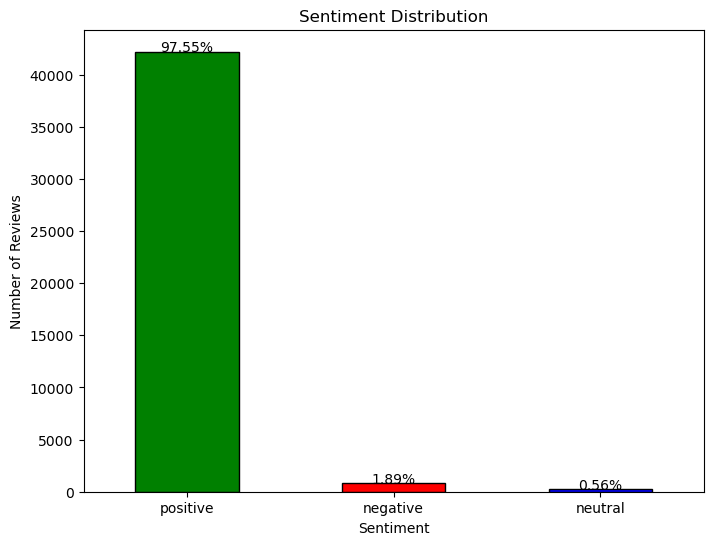

In [47]:
#A run
sentiment_counts = combined_df["sentiment_label"].value_counts()
total_reviews = sentiment_counts.sum()
sentiment_percentages = (sentiment_counts / total_reviews * 100).round(2)

# Step 3: Create a DataFrame for sentiment analysis
sentiment_analysis = pd.DataFrame({
    "count": sentiment_counts,
    "percentage": sentiment_percentages
})

print(sentiment_analysis)

# Step 4: Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind="bar", color=["green", "red", "blue"], edgecolor="black")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)

# Add percentages on top of the bars
for index, value in enumerate(sentiment_counts):
    percentage = sentiment_percentages.iloc[index]
    plt.text(index, value + total_reviews * 0.01, f"{percentage}%", ha="center", fontsize=10)

plt.show()

Neg (Negative Sentiment)
Represents the proportion of review that conveys negative sentiment.
Ranges between 0 and 1.
A higher value indicates a stronger negative sentiment in the review.

Neu (Neutral Sentiment)
Represents the proportion of review that is neutral or without sentiment.
Ranges between 0 and 1.
A higher value indicates more of the text is neutral.

Pos (Positive Sentiment)
Represents the proportion of review that conveys positive sentiment.
Ranges between 0 and 1.
A higher value indicates a stronger positive sentiment in the review.

Compound (Overall Sentiment Score)
A normalized, weighted composite score of the sentiment in the review.
Ranges between -1 and 1:
1 indicates extremely positive sentiment.
-1 indicates extremely negative sentiment.
0 indicates neutral sentiment.
Calculated by combining the pos, neu, and neg scores using a predefined formula, emphasizing extreme values.
Thresholds for Interpretation:

compound >= 0.05: Positive sentiment
compound <= -0.05: Negative sentiment
-0.05 < compound < 0.05: Neutral sentiment

# Comparison between both

Répartition des sentiments (globalement et par plateforme)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les fichiers analysés contenant les sentiments
ba_sentiment = pd.read_csv('./output_with_sentiment/sentiment_ba_reviews.csv')
rb_sentiment = pd.read_csv('./output_with_sentiment/sentiment_rb_reviews.csv')

# Ajouter une colonne pour indiquer la plateforme
ba_sentiment['platform'] = 'BeerAdvocate'
rb_sentiment['platform'] = 'RateBeer'

# Fusionner les deux DataFrames
all_data = pd.concat([ba_sentiment, rb_sentiment], ignore_index=True)

# Calculer les proportions des sentiments par plateforme
sentiment_distribution = all_data.groupby(['platform', 'sentiment_label']).size().reset_index(name='count')
sentiment_distribution['proportion'] = sentiment_distribution.groupby('platform')['count'].apply(lambda x: x / x.sum())

# Visualisation
fig, ax = plt.subplots(figsize=(8, 6))
for platform in sentiment_distribution['platform'].unique():
    subset = sentiment_distribution[sentiment_distribution['platform'] == platform]
    ax.bar(subset['sentiment_label'], subset['proportion'], label=platform, alpha=0.7)

ax.set_title('Sentiment Distribution by Platform')
ax.set_ylabel('Proportion')
ax.set_xlabel('Sentiment Label')
ax.legend(title='Platform')
plt.show()

Intensité moyenne des sentiments